## 环境

Tensorflow 在近期版本中做了 API 的更改，如果 Tensorflow 版本太老导致无法运行本 notebook 中的代码，建议可以执行 `!pip install --upgrade tensoflow` 进行升级。

In [2]:
%load_ext watermark

In [3]:
%watermark

2017-03-21T18:57:18+08:00

CPython 3.5.2
IPython 5.2.2

compiler   : GCC 4.9.2
system     : Linux
release    : 3.16.0-4-amd64
machine    : x86_64
processor  : 
CPU cores  : 4
interpreter: 64bit


In [4]:
import tensorflow as tf
print(tf.__version__)

1.0.1


## sympy

In [26]:
# Insall
!pip install sympy

You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [27]:
import sympy
sympy.init_printing(use_unicode=True)

In [28]:
x = sympy.symbols('x')
w, b = sympy.symbols('w b')

In [29]:
sympy.diff(w * sympy.sin(x) + b, x)

In [30]:
x ** 2

## Tensorflow 实现线性回归

In [31]:
%matplotlib inline
from matplotlib import pyplot as plt

In [32]:
import tensorflow as tf
import numpy as np

In [66]:
tf.reset_default_graph()

## Constant

In [67]:
c = tf.constant([1, 2, 3])
print(c)

Tensor("Const:0", shape=(3,), dtype=int32)


In [68]:
type(c)

tensorflow.python.framework.ops.Tensor

- `Constant` 是一种 `Tensor`
    - `Tensor` 类似 numpy 中的 array。我们常用的是一维（向量）、二维（矩阵）结构
- 为什么 `print` 看不到 `c` 的值
    - 在这里只是『声明』了这个 `Tensor`

In [69]:
g = tf.get_default_graph()
g.as_graph_def()

node {
  name: "Const"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_INT32
        tensor_shape {
          dim {
            size: 3
          }
        }
        tensor_content: "\001\000\000\000\002\000\000\000\003\000\000\000"
      }
    }
  }
}
versions {
  producer: 21
}

- Tensorflow 中会有一个默认的 "Graph"，所有『声明』的操作都记录在这个 Graph 上
- Gapraph 要通过 Session 来执行

In [36]:
sess = tf.Session()
sess.run(c)

array([1, 2, 3], dtype=int32)

In [37]:
with tf.Session() as sess:
    r = sess.run(c)
    print(type(r))
    print(r)

<type 'numpy.ndarray'>
[1 2 3]


- `c` 在 Graph 里是一个 Tensor，Session 执行之后返回的是 numpy array
- Graph: 执行蓝图（有向无环图）
- Session: 具体执行

好处是什么：
- 可并行
- Graph 的不同部分可以放到不同的设备上

Tensorflow Graph 上的两种 Node:
- Tensor
- Operation

In [38]:
c2 = c + c
print(c2)

Tensor("add_1:0", shape=(3,), dtype=int32)


- 添加了一个 Node: "Add" 的 Operation

In [39]:
with tf.Session() as sess:
    print(sess.run(c2))

[2 4 6]


### 随机数

In [40]:
sess = tf.Session()

In [41]:
r = tf.random_uniform([1], -1.0, 1.0)
r

<tf.Tensor 'random_uniform_2:0' shape=(1,) dtype=float32>

- 返回的也是 Tensor

In [42]:
sess.run(r)

array([ 0.53045559], dtype=float32)

### Variable 的概念
- Tensorflow 中的 Variable 对机器学习应用至关重要
- 用 Tensor 赋值，能做 Tensor 相同的操作
- 和编程中『变量』的概念类似，用于维护一个可变的状态
- 不同 `run` 之间能保存状态
- 适合做什么？

y = w * x + b

In [43]:
w = tf.Variable(tf.random_uniform([1], -1.0, 1.0), name='W')
b = tf.Variable(tf.zeros([1]), name='b')

In [44]:
# 这里会产生错误
sess = tf.Session()
sess.run(b)

FailedPreconditionError: Attempting to use uninitialized value b_1
	 [[Node: _send_b_1_0 = _Send[T=DT_FLOAT, client_terminated=true, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1188446501205305038, tensor_name="b_1:0", _device="/job:localhost/replica:0/task:0/cpu:0"](b_1)]]

- "Attempting to use uninitialized value W_1"
    - Why?
- 变量需要一个专门的初始化过程
    - 可以使用 tf.global_variables_initializer() 增加一个 operation，初始化所有变量

In [45]:
init = tf.global_variables_initializer()
sess.run(init)
sess.run(w)

array([-0.5388031], dtype=float32)

In [46]:
# 变量不动
sess.run(w)

array([-0.5388031], dtype=float32)

In [47]:
# 重新初始化变量
sess.run(init)
sess.run(w)

array([-0.8764379], dtype=float32)

- 有了变量，我们知道还要有数据才能计算 Cost

In [48]:
x = np.arange(0, 20)
y = x + np.random.normal(size=20)

In [49]:
x

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [50]:
y

array([ -3.08723974,   2.15298905,   1.42123157,   1.22070167,
         4.87721665,   3.83766926,   6.03221913,   6.8908403 ,
         8.63200909,   7.98058748,  10.71651146,  11.57580402,
        12.74190545,  14.01099132,  13.70979907,  14.14814602,
        16.00000616,  17.72508553,  18.30866392,  18.41548932])

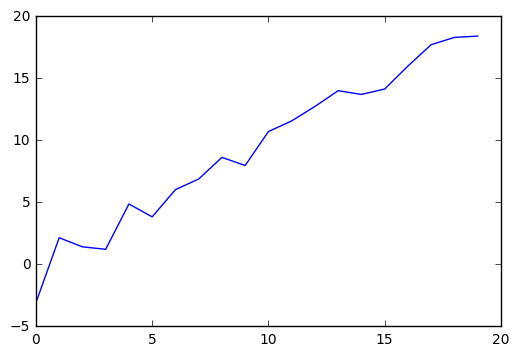

In [51]:
plt.plot(x, y)

In [52]:
tf.reset_default_graph()

In [53]:
w = tf.Variable(tf.random_uniform([1], -1.0, 1.0), name='W')
b = tf.Variable(tf.zeros([1]), name='b')

# x: numpy array
# 模型的预测值
# Y_bar 没有值，只是一个操作的声明
y_bar = w * x + b
cost = tf.reduce_mean((y_bar - y) ** 2)

In [54]:
(y_bar - y) ** 2

<tf.Tensor 'pow_1:0' shape=(20,) dtype=float32>

In [55]:
s = tf.Session()
s.run(tf.reduce_mean([1,2,3]))

2

In [56]:
cost

<tf.Tensor 'Mean:0' shape=() dtype=float32>

In [57]:
y_bar

<tf.Tensor 'add:0' shape=(20,) dtype=float32>

In [58]:
s.run(tf.global_variables_initializer())
print(s.run(cost))

340.499


In [59]:
y_bar = np.asarray([-0.11136627]) * x + 0

In [60]:
np.mean((y_bar - y) ** 2)

### 梯度下降

In [61]:
train_step = tf.train.GradientDescentOptimizer(0.0001).minimize(cost)
costs = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(100):
        sess.run(train_step)
        cost_value = sess.run(cost)
        costs.append(cost_value)
        print(cost_value)
        print(sess.run([w, b]))

30.5734
[array([ 0.51675791], dtype=float32), array([ 0.00091478], dtype=float32)]
29.1278
[array([ 0.52882373], dtype=float32), array([ 0.00180586], dtype=float32)]
27.7531
[array([ 0.54058981], dtype=float32), array([ 0.00267384], dtype=float32)]
26.4459
[array([ 0.55206364], dtype=float32), array([ 0.00351929], dtype=float32)]
25.2029
[array([ 0.56325245], dtype=float32), array([ 0.00434277], dtype=float32)]
24.0209
[array([ 0.57416332], dtype=float32), array([ 0.00514483], dtype=float32)]
22.8968
[array([ 0.58480316], dtype=float32), array([ 0.005926], dtype=float32)]
21.828
[array([ 0.59517872], dtype=float32), array([ 0.00668679], dtype=float32)]
20.8116
[array([ 0.60529655], dtype=float32), array([ 0.00742772], dtype=float32)]
19.845
[array([ 0.61516309], dtype=float32), array([ 0.00814928], dtype=float32)]
18.9259
[array([ 0.62478453], dtype=float32), array([ 0.00885194], dtype=float32)]
18.0519
[array([ 0.63416702], dtype=float32), array([ 0.00953619], dtype=float32)]
17.2208


In [ ]:
plt.plot(costs)

## Placeholder
- Graph 是『虚』的，数据是『实』的
- 先用一个『虚』的 Node 替代『实』的数据

In [ ]:
tf.reset_default_graph()

In [ ]:
x_placeholder = tf.placeholder('float')
y_placeholder = tf.placeholder('float')

w = tf.Variable(tf.random_uniform([1], -1.0, 1.0), name='W')
b = tf.Variable(tf.zeros([1]), name='b')

y_bar = w * x_placeholder + b
cost = tf.reduce_mean(tf.square(y_bar - y_placeholder))

In [ ]:
train_step = tf.train.GradientDescentOptimizer(0.0001).minimize(cost)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(100):
        feed_dict = {x_placeholder:x.astype(float), y_placeholder:y}
        sess.run(train_step, feed_dict=feed_dict)
        print(sess.run(cost, feed_dict=feed_dict))
        print(sess.run([w, b]))

## write data

In [ ]:
writer = tf.summary.FileWriter("/tensorflow/tf", graph=tf.get_default_graph())

如果在 Docker 环境中进行可视化，可以多暴露一个端口，如
`docker run -it -p 1234:1234 -p 8888:8888`

如果想在已有环境的基础上添加端口，可以参考 ch1 答疑中 Docker 环境使用的 commit + run大法。

在导出的目录处运行 `tensorboard --port 1234 --logdir=tf`，本机即可访问 Tensorboard 服务了。